In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("monthly_avg_price.csv")  
df.head()

,month_year,product,store_id,COICOP5,COICOP4,price
0,2020-12,abate arg biologico 600.0 gr,6,Pears,Fruit,2.98
1,2020-12,abate arg biologico 600.0 gr,7,Pears,Fruit,2.98
2,2020-12,abate arg biologico 600.0 gr,10,Pears,Fruit,2.98
3,2020-12,abate arg biologico 600.0 gr,15,Pears,Fruit,2.98
4,2020-12,abate arg biologico 600.0 gr,16,Pears,Fruit,2.98


In [5]:
# define unique series keys & sort by date 

df = df.sort_values(['product', 'store_id', 'COICOP5', 'month_year']).copy()

series_keys = df[['product', 'store_id', 'COICOP5']].drop_duplicates()

series_keys.head()

,product,store_id,COICOP5
0,abate arg biologico 600.0 gr,6,Pears
1,abate arg biologico 600.0 gr,7,Pears
109424,abate arg biologico 600.0 gr,9,Pears
2,abate arg biologico 600.0 gr,10,Pears
3,abate arg biologico 600.0 gr,15,Pears


In [11]:
#generate quantities function

def generate_quantity_series(prices, leader=False, region_factor=1.0, store_factor=1.0, seed=None):
    rng = np.random.default_rng(seed)
    n = len(prices)
    
    # Base level, higher if leader
    base = rng.uniform(300, 500) if leader else rng.uniform(50, 150)
    
    # Apply region/store multipliers
    base *= store_factor
    
    # Seasonal/random variation
    noise = rng.normal(0, 10, n)
    
    # Price elasticity: quantities dip when price rises
    elasticity = -0.2
    quantities = base + elasticity * (prices - np.mean(prices)) * base + noise
    
    return np.maximum(quantities, 1)

# assign store factors
store_factors  = {s: f for s, f in zip(df['store_id'].unique(), np.linspace(0.9, 1.1, len(df['store_id'].unique())))}

In [13]:
#apply to each series

df['quantity'] = 0.0

# mark 20% of product-store combos as leaders
leader_keys = series_keys.sample(frac=0.2, random_state=42)

for _, row in series_keys.iterrows():
    pid, sid, coicop = row
    
    mask = (
        (df['product'] == pid) &
        (df['store_id'] == sid) &
        (df['COICOP5'] == coicop)
    )
    
    prices = df.loc[mask, 'price'].values
    
    # Leader if in leader_keys
    is_leader = ((leader_keys['product'] == pid) &
                 (leader_keys['store_id'] == sid) &
                 (leader_keys['COICOP5'] == coicop)).any()
    
    q_series = generate_quantity_series(
        prices,
        leader=is_leader,
        store_factor=store_factors[sid],
        seed=hash((pid, sid, coicop)) % 2**32
    )
    
    df.loc[mask, 'quantity'] = q_series

In [42]:
#check output
df.head(100)

,month_year,product,store_id,COICOP5,COICOP4,price,quantity
0,2020-12,abate arg biologico 600.0 gr,6,Pears,Fruit,2.98,443.952624
6136,2021-01,abate arg biologico 600.0 gr,6,Pears,Fruit,2.98,462.090255
12830,2021-02,abate arg biologico 600.0 gr,6,Pears,Fruit,2.98,451.617279
19584,2021-03,abate arg biologico 600.0 gr,6,Pears,Fruit,2.98,439.133107
26499,2021-04,abate arg biologico 600.0 gr,6,Pears,Fruit,3.78,378.187192
...,...,...,...,...,...,...,...
46523,2021-07,aglio bianco umbria 200.0 gr,8,"Roots, Bulbs, Mushrooms and Other Vegetables",Vegetable,1.49,76.760014
52628,2021-08,aglio bianco umbria 200.0 gr,8,"Roots, Bulbs, Mushrooms and Other Vegetables",Vegetable,1.49,70.708473
58541,2021-09,aglio bianco umbria 200.0 gr,8,"Roots, Bulbs, Mushrooms and Other Vegetables",Vegetable,1.49,82.911132
64609,2021-10,aglio bianco umbria 200.0 gr,8,"Roots, Bulbs, Mushrooms and Other Vegetables",Vegetable,1.49,68.945600


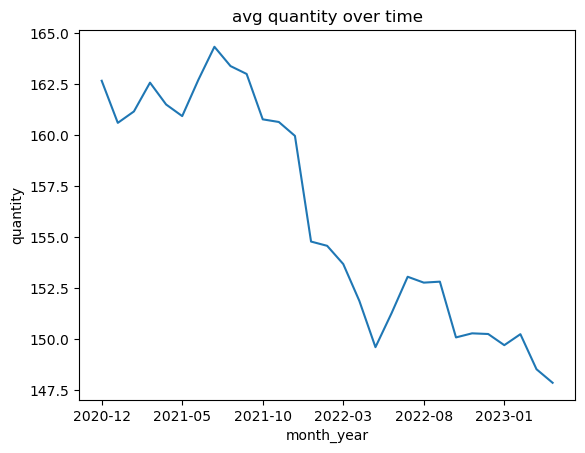

In [22]:
#review quantities
df.groupby("month_year")["quantity"].mean().plot()
plt.title("avg quantity over time")
plt.ylabel("quantity")
plt.show()

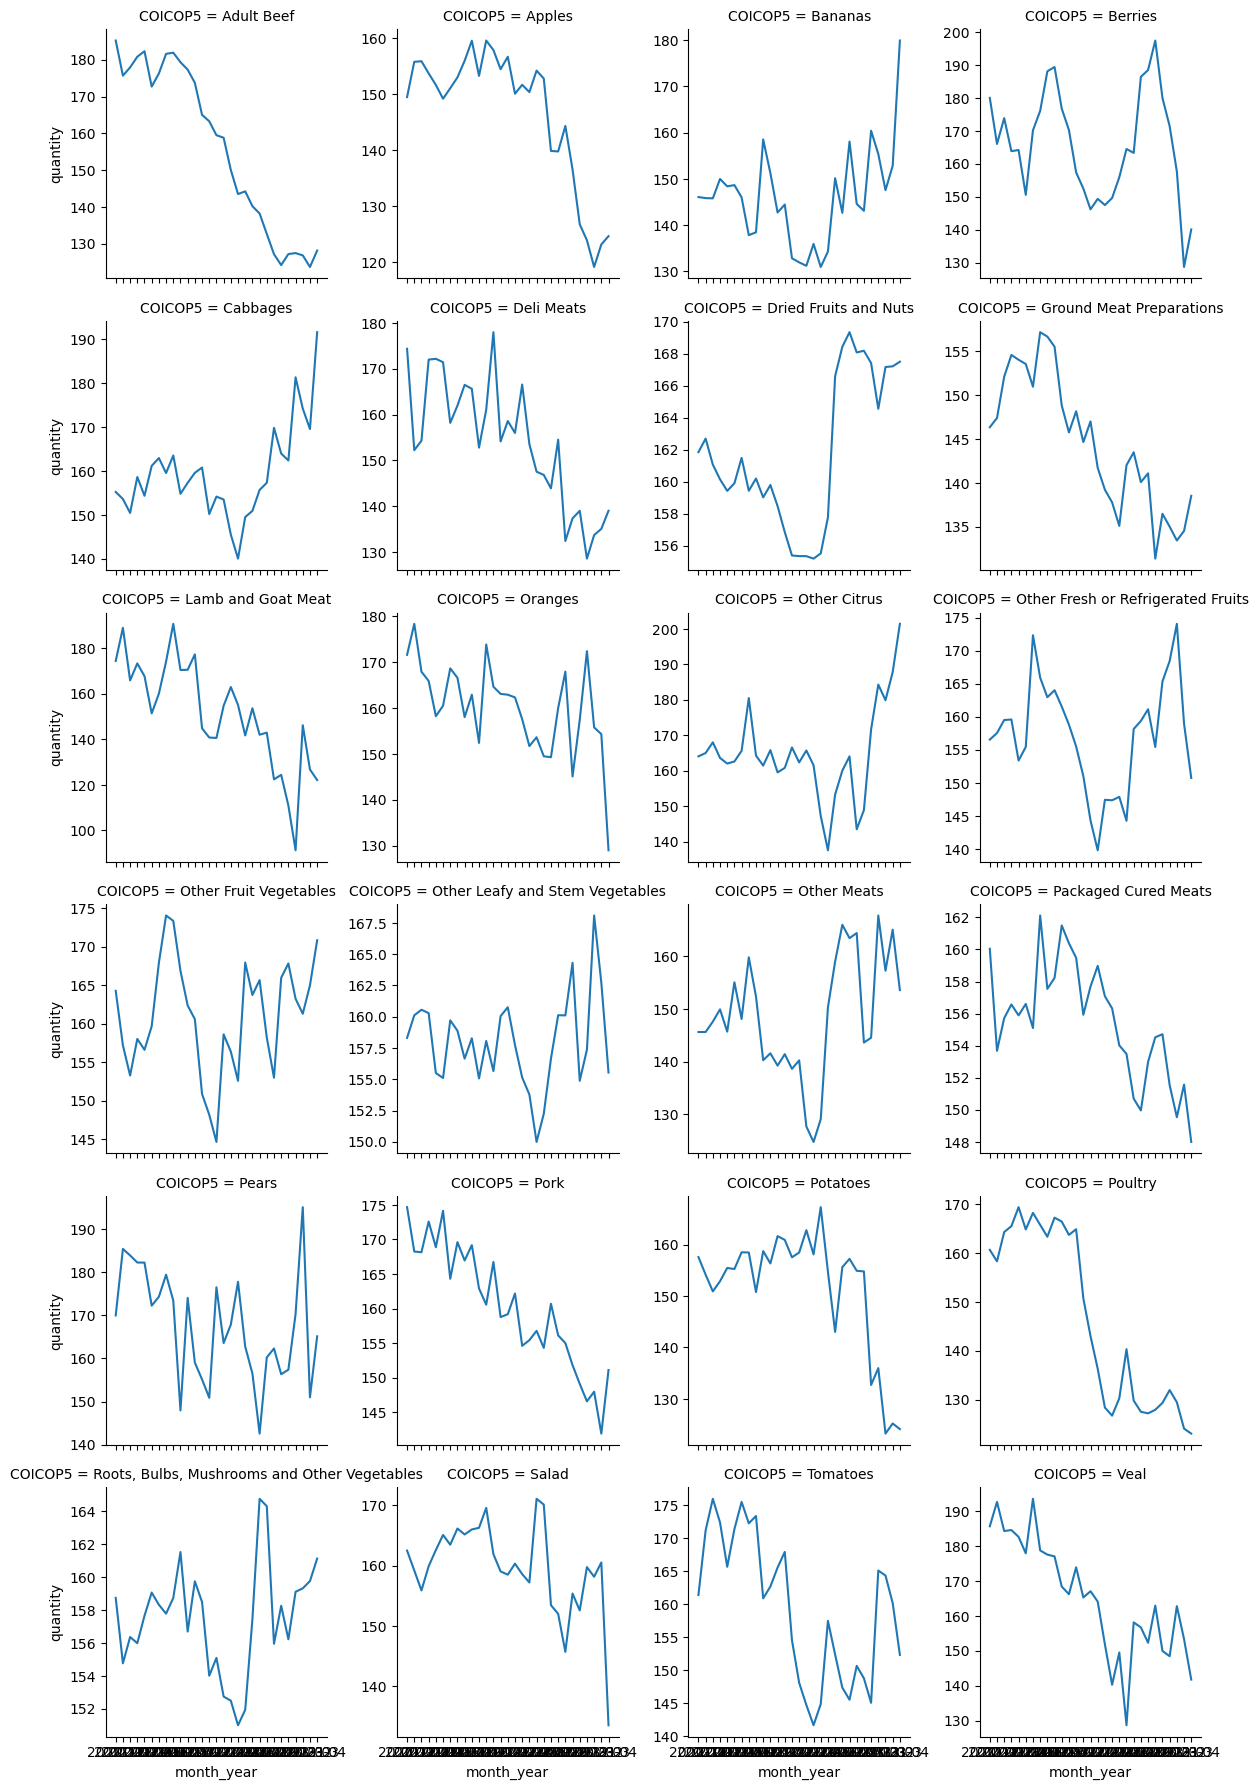

In [31]:
# mean quantity per date and COICOP5
coicop_trends = df.groupby(["month_year", "COICOP5"])["quantity"].mean().reset_index()

sns.relplot(
    data=coicop_trends,
    x="month_year", y="quantity",
    kind="line", col="COICOP5", col_wrap=4,
    height=3, facet_kws={'sharey': False}
)
plt.show()

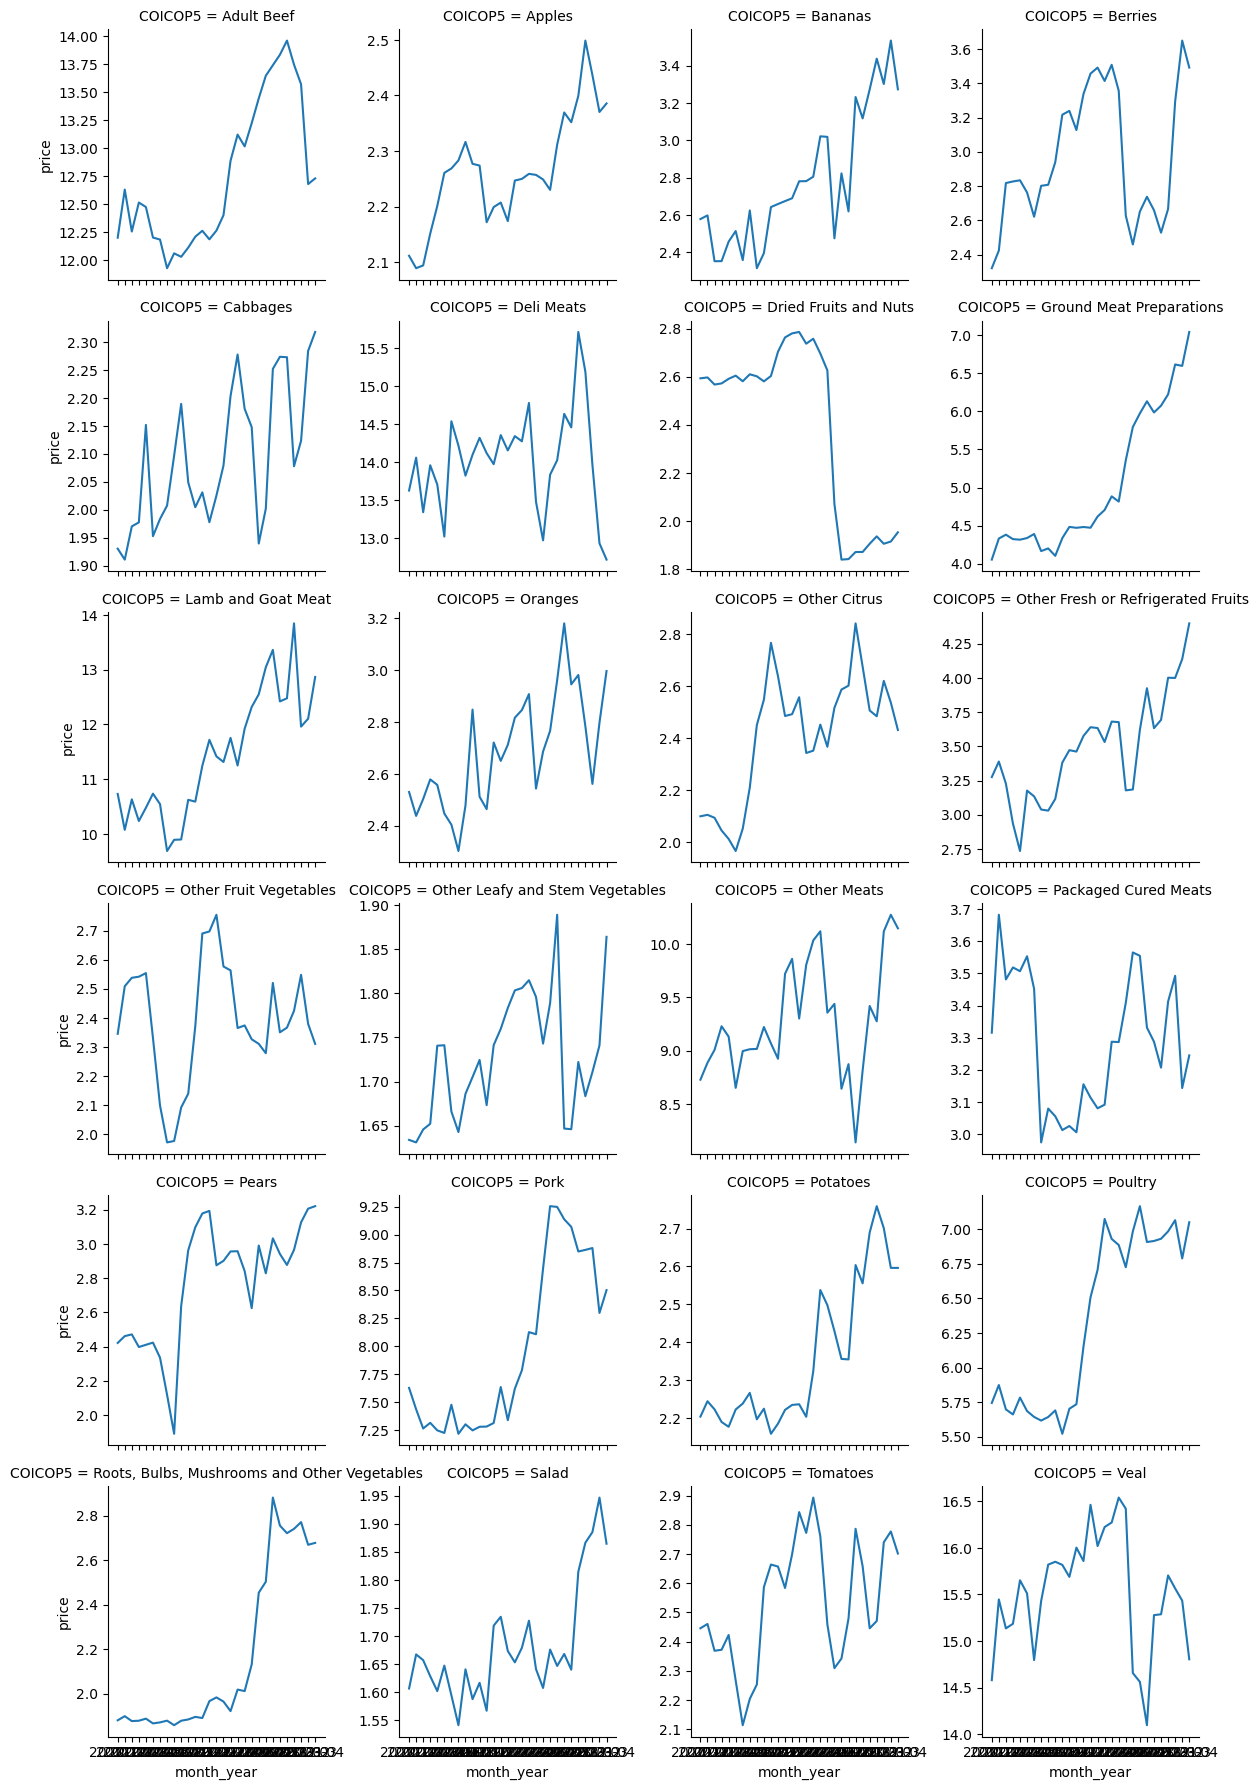

In [32]:
# Mean price per date and COICOP5
coicop_trends = df.groupby(["month_year", "COICOP5"])["price"].mean().reset_index()

sns.relplot(
    data=coicop_trends,
    x="month_year", y="price",
    kind="line", col="COICOP5", col_wrap=4,
    height=3, facet_kws={'sharey': False}
)
plt.show()

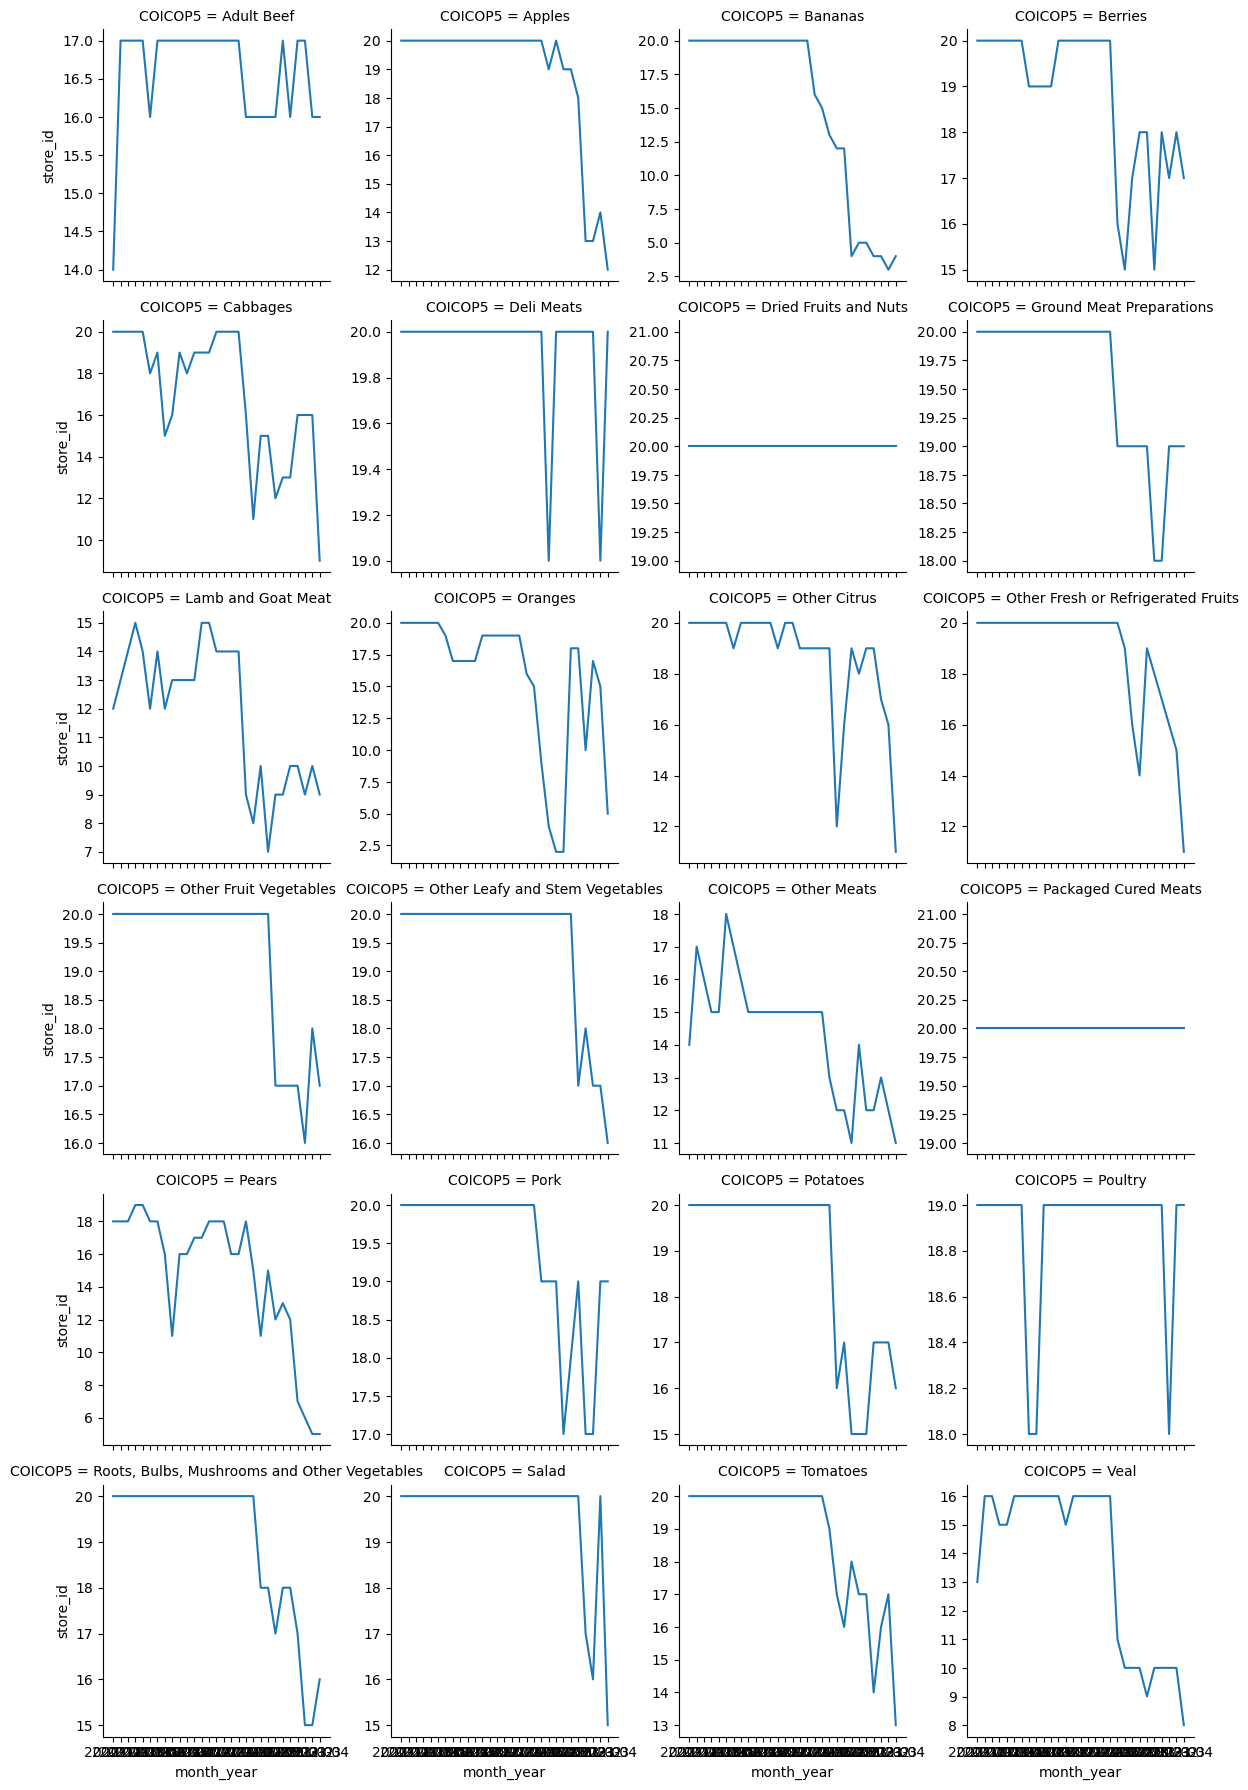

In [38]:
# count number of stores over time
coicop_trends = df.groupby(["month_year", "COICOP5"])["store_id"].nunique().reset_index()

sns.relplot(
    data=coicop_trends,
    x="month_year", y="store_id",
    kind="line", col="COICOP5", col_wrap=4,
    height=3, facet_kws={'sharey': False}
)
plt.show()

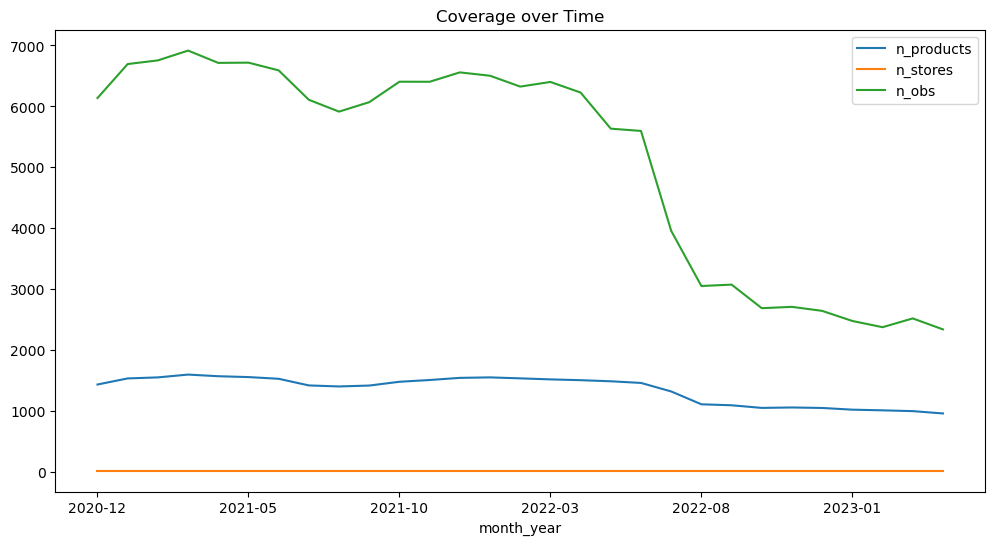

In [34]:
#investigate data

coverage = df.groupby("month_year").agg(
    n_products=("product", "nunique"),
    n_stores=("store_id", "nunique"),
    n_obs=("product", "count")
).reset_index()

coverage.plot(x="month_year", y=["n_products","n_stores","n_obs"], figsize=(12,6))
plt.title("Coverage over Time")
plt.show()

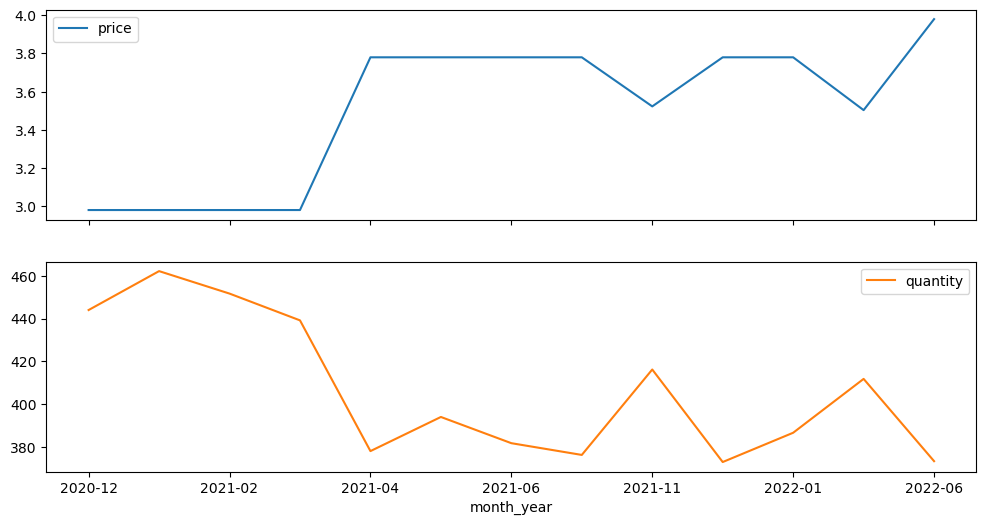

In [43]:
#check volatility of quantities for specific products in specific stores 
example = df[(df["product"]=="abate arg biologico 600.0 gr") & (df["store_id"]==6)]
example.plot(x="month_year", y=["price","quantity"], subplots=True, figsize=(12,6))
plt.show()

In [45]:
#explore price/quantity correlation
corrs = df.groupby("product")[["price","quantity"]].corr().iloc[0::2,-1]
print(corrs.describe())

count    1642.000000
mean       -0.230493
std         0.384173
min        -1.000000
25%        -0.478835
50%        -0.171899
75%         0.002347
max         1.000000
Name: quantity, dtype: float64


In [44]:
df.to_csv("monthly_with_qty.csv", index=False)